# Quasicrystal optical system
by T. A. Corcovilos

This is the code used to generate the simulation results found in the paper

Corcovilos, T. A., & Mittal, J. (2019). Two-dimensional optical quasicrystal potentials for ultracold atom experiments, _Applied Optics_ *58* (9), 2256–2263. [doi:10.1364/AO.58.002256](http://dx.doi.org/10.1364/AO.58.002256) or [arXiv:1903.06610](http://arxiv.org/abs/1903.06610)

### Version
20181127 - This version includes the apodization mask

In [2]:
#%matplotlib notebook
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
#from __future__ import (division, print_function)
import numpy as np
import scipy.special
import scipy.ndimage.interpolation
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import astropy.units as u
import warnings
import poppy
from poppy import utils
from poppy.poppy_core import OpticalElement, Wavefront, PlaneType, _PUPIL, _IMAGE, _RADIANStoARCSEC

from poppy import fresnel

from copy import deepcopy
import matplotlib.colors
import matplotlib.ticker as ticker
import matplotlib.style
from matplotlib_scalebar.scalebar import ScaleBar

In [3]:
# To install missing libraries, uncomment the lines below
#!pip install poppy
#!pip install matplotlib_scalebar

In [4]:
# image parameters
josadpi = 600 # resolution
josawidth = 8.4/2.54 # column width in inches

In [5]:
poppy.conf.cmap_pupil_intensity='binary' # set inverted grayscale for intensity plots

In [6]:
%matplotlib inline

In [7]:
class FiberBundle(poppy.AnalyticOpticalElement):
    """ Defines a circular bundle of fibers
    Parameters
    ----------
    name : string
        Descriptive name
    fiber_radius : float
        Radius of a fiber aperture, in meters. Default is 1.0
    number: int
        Number of fibers
    bundle_radius: float
        Radius of the bundle, in meters. Default is 1.0
    gaussian: bool
        Use gaussian apodization of fibers.  Otherwise use step apodization.  Default is False.
    mode_radius: float
        gaussian mode radius (req. if gaussian=True)
    tilt: float 
        Tilt angle of fibers in radian, away from the axis.  Default is 0.0.
    pad_factor : float, optional
        Amount to oversize the wavefront array relative to this pupil.
        This is in practice not very useful, but it provides a straightforward way
        of verifying during code testing that the amount of padding (or size of the circle)
        does not make any numerical difference in the final result.
    pd : array of floats with length equal to "number".  Default is np.zeros(10)
        Array with relative path difference for each fiber
    x_scale, y_scale: floats to scale the x and y positions of the fibers
    """

    #@utils.quantity_input(fiber_radius=u.meter,bundle_radius=u.meter)
    def __init__(self, name=None, fiber_radius=1.0*u.meter, number=1, bundle_radius=1.0*u.meter,
                 pad_factor=1.0, planetype=PlaneType.unspecified, gaussian=False, mode_radius=None,
                 tilt=0.0, pd=np.zeros(10), x_scale = 1.0, y_scale = 1.0,
                 **kwargs):

        if name is None:
            name = "Bundle, number={}, radius={}".format(number,bundle_radius)
        super(FiberBundle, self).__init__(name=name, planetype=planetype, **kwargs)
        self.fiber_radius=fiber_radius
        self.bundle_radius=bundle_radius
        self.number=number
        self.gaussian=gaussian
        if gaussian:
            if mode_radius is None:
                raise ValueError("Gaussian requires mode_radius to be defined")
            else:
                self.mode_radius = mode_radius
        self.tilt=tilt
        # for creating input wavefronts - let's pad a bit:
        self.pupil_diam = pad_factor * 4 * self.bundle_radius
        self.pd=pd
        self.x_scale = x_scale
        self.y_scale = y_scale
        
    def get_transmission(self, wave):
        """ Compute the transmission inside/outside of the aperture.
        """
        if not isinstance(wave, Wavefront):  # pragma: no cover
            raise ValueError("FiberBundle get_transmission must be called with a Wavefront "
                             "to define the spacing")
        assert (wave.planetype != _IMAGE)
        
        if hasattr(self, "__transmission") and wave == self.__oldtwave:
            return self.__transmission #reuse earlier calculation
                
        fibercenters_ang = np.arange(self.number)*2*np.pi/self.number
        fibercenters_x = np.cos(np.array(fibercenters_ang))*self.bundle_radius*self.x_scale
        fibercenters_y = np.sin(np.array(fibercenters_ang))*self.bundle_radius*self.y_scale
      
        y, x = self.get_coordinates(wave)
        transmission = np.zeros(wave.shape)
        for j in range(self.number):
            r = (x-fibercenters_x[j])**2 + (y-fibercenters_y[j])**2
            inside=np.where(r<=self.fiber_radius**2)
            if self.gaussian == True:
                #r0 = np.zeros(wave.shape)
                r0 = np.exp(-2*r/self.fiber_radius**2)
                transmission[inside] += r0[inside]
                del r0
            else:
                transmission[inside] += 1
        #self.transmission = self.transmission/self.transmission.max()
        del x
        del y
        del r
        self.__oldtwave = wave
        self.__transmission = transmission
        return transmission
    
    def get_opd(self,wave):
        opd = np.zeros(wave.shape)
        if (self.tilt!=0.0):
            fibercenters_ang = np.arange(self.number)*2*np.pi/self.number
            fibercenters_x = np.cos(np.array(fibercenters_ang))*self.bundle_radius
            fibercenters_y = np.sin(np.array(fibercenters_ang))*self.bundle_radius
        
            y, x = self.get_coordinates(wave)
            
            fiberNum = np.array(np.mod(np.rint(np.arctan2(y,x)*self.number*0.5/np.pi),self.number),dtype=int) #id of closest fiber
            alpha = np.remainder(fiberNum,self.number)/self.number*2.0*np.pi #azimuthal angle of fiber center
            x0 = fibercenters_x[fiberNum]
            y0 = fibercenters_y[fiberNum]
            opd = np.tan(self.tilt)*((x-x0)*np.cos(alpha)+(y-y0)*np.sin(alpha))+np.choose(fiberNum,self.pd) #closest fiber sets angles.  Better approx to sum all fibers
            opaque = np.where(self.get_transmission(wave) == 0)
            opd[opaque] = 0
            
        return opd

In [8]:
class ApodMask(poppy.AnalyticOpticalElement):
    """ Defines an inverse gaussian apodization mask
    Parameters
    ----------
    name : string
        Descriptive name
    cutoff_radius: float, optional
        The outer radius of the mask.  Beyond this, the transmission is zero
    mode_radius: float, required
        The 1/e^2 radius of the apodization curve
    min_attenuation: float, optional
        attenuation at edge of mask.  If blank, default is zero
    pad_factor : float, optional
        Amount to oversize the wavefront array relative to this pupil.
        This is in practice not very useful, but it provides a straightforward way
        of verifying during code testing that the amount of padding (or size of the circle)
        does not make any numerical difference in the final result.
    pd : array of floats with length equal to "number".  Default is np.zeros(10)
        Array with relative path difference for each fiber
    """

    #@utils.quantity_input(mode_radius=u.meter, cutoff_radius=u.meter)
    def __init__(self, mode_radius, cutoff_radius=0.0, min_attenuation=1e-10, name=None, 
                 pad_factor=1.0, planetype=PlaneType.unspecified, 
                 **kwargs):

        if name is None:
            name = "Antigauss mask, cutoff={}, mode_radius={}, min_att={}".format(cutoff_radius,mode_radius,min_attenuation)
        super(ApodMask, self).__init__(name=name, planetype=planetype, **kwargs)
        self.mode_radius = mode_radius
        if cutoff_radius==0.0:
            self.cutoff_radius = 5.0*mode_radius
        else:
            self.cutoff_radius = cutoff_radius
        self.min_attenuation = min_attenuation
        # for creating input wavefronts - let's pad a bit:
        self.pupil_diam = pad_factor * 4 * self.cutoff_radius
        
    def get_transmission(self, wave):
        """ Compute the transmission inside/outside of the aperture.
        """
        if not isinstance(wave, Wavefront):  # pragma: no cover
            raise ValueError("ApodMask get_transmission must be called with a Wavefront "
                             "to define the spacing")
        assert (wave.planetype != _IMAGE)
        
        if hasattr(self, "__transmission") and wave == self.__oldtwave:
            return self.__transmission #reuse earlier calculation
                
        y, x = self.get_coordinates(wave)
        r2 = (y**2 + x**2)*u.meter**2 # radius squared
        k = self.min_attenuation
        transmission = 1.0-k*np.exp(-r2/self.mode_radius**2)
        transmission = np.clip(transmission,0.,1.) # just to be sure
        del x
        del y
        del r2
        self.__oldtwave = wave
        self.__transmission = transmission
        return transmission

    def display_trans(self, radius=0., npix=2048, irrad=False, log=False):
        if radius == 0.: # catch default and overwrite
            radius = 2.*self.cutoff_radius
        wave = poppy.Wavefront(diam=2*radius,npix=npix)
        if irrad:
            trans = self.get_transmission(wave)**2
        else:
            trans = self.get_transmission(wave)
        if log:
            trans = np.log10(trans)
        y, x = self.get_coordinates(wave)
        fig=plt.figure()
        ax=plt.axes()
        plt.plot(x[npix//2,:],trans[npix//2,:])
        plt.xlabel("Position")
        if irrad:
            plt.ylabel("Irradiance Transmission")
        else:
            plt.ylabel("Amplitude Transmission")
        return fig, ax

In [9]:
def phasorplot(wave, optic=None, name="Phasor plot", crop=0.5, invert=False, bare=False):
    fig=plt.figure()
    ax=plt.axes()
    if optic == None:
        amp = wave.amplitude
        phase = (wave.phase / (2.0*np.pi)) % 1 #phase in waves
    else:
        amp = optic.get_transmission(wave)
        phase = (optic.get_opd(wave) / wave.wavelength.value) % 1.0
    ashape = wave.shape
    #crop away padding with these cuts: (crop = 0.5 only removes numerical padding.  Smaller number will remove outer parts of the image.)
    pxmin = np.int(ashape[0]*0.5*(1-crop)); pxmax = np.int(ashape[0]*0.5*(1+crop))
    pymin = np.int(ashape[1]*0.5*(1-crop)); pymax = np.int(ashape[1]*0.5*(1+crop))
    y, x = wave.coordinates()
    # apply crops
    x = x[pxmin:pxmax,pymin:pymax]
    y = y[pxmin:pxmax,pymin:pymax]
    amp = amp[pxmin:pxmax,pymin:pymax]
    phase = phase[pxmin:pxmax,pymin:pymax]
    h = phase
    if invert:
        v = np.ones(amp.shape)
        s = amp/amp.max()
    else:
        s = np.ones(amp.shape)
        v = amp/amp.max()
    hsv = np.moveaxis(np.array([h,s,v]), [0,1,2], [2,0,1])
    rgb = matplotlib.colors.hsv_to_rgb(hsv)
    halfpix = wave.pixelscale.value*0.5
    extent = np.array([x.min()-halfpix, x.max()+halfpix, y.min()-halfpix, y.max()+halfpix])*1e3 # convert to mm
    #print("coords = {}".format(np.array([pxmin,pxmax,pymin,pymax])))
    #print("extent = {}".format(extent))
    plt.imshow(rgb, extent=extent)
    if not bare:
        #plt.title(name)
        plt.xlabel("Position (mm)")
        plt.ylabel("Position (mm)")
        
    else:
        ax.set_frame_on(False)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    ax.grid(False)
    fig.tight_layout()
    return fig, ax

In [10]:
def myintensityplot(thiswave, crop=0.5, invert=False, **kwargs):
    #%matplotlib notebook
    #plt.ion()
    matplotlib.style.use('default')
    fig = plt.figure()
    ax = plt.axes()
    halfpix = thiswave.pixelscale.value*0.5
    ashape = thiswave.shape
    #crop away padding with these cuts: (crop = 0.5 only removes numerical padding.  Smaller number will remove outer parts of the image.)
    pxmin = np.int(ashape[0]*0.5*(1-crop)); pxmax = np.int(ashape[0]*0.5*(1+crop))
    pymin = np.int(ashape[1]*0.5*(1-crop)); pymax = np.int(ashape[1]*0.5*(1+crop))
    y, x = thiswave.coordinates()
    x = x[pxmin:pxmax,pymin:pymax]
    y = y[pxmin:pxmax,pymin:pymax]
    amp = (thiswave.amplitude[pxmin:pxmax,pymin:pymax])**2 # square to get irradiance
    amp *= 1.0/amp.max() #normalize
    if invert:
        amp = 1.0-amp
    extent = np.array([x.min()-halfpix, x.max()+halfpix, y.min()-halfpix, y.max()+halfpix])*1e6 # convert to microns
    plt.imshow(amp, cmap='gist_yarg', extent=extent, aspect='equal', interpolation='none', **kwargs)
    plt.xlabel(u"Position (μm)");
    plt.ylabel(u"Position (μm)");
    ax.grid(False)
    fig.tight_layout()
    #plt.show()
    return fig, ax

Lenses from OZ optics can be found in http://www.ozoptics.com/ALLNEW_PDF/DTS0079.pdf starting on page 8.  Best choice seems to be "Standard Aspheric Lenses" in Table 11A, page 11.

Likely options for &lambda; = 800 nm:

| Bar Code | Lens ID | f (mm) | OD (mm) | Aperture (mm) | Collimator |
| --- | --- | --- | --- | --- | --- |
| 504 | 1.4AS | 1.45 |2.4 | 1.6 | LPC-01, LPC-02, LPC-03, LPSC-03 |
| 519 | 2AS | 2.00 | 3.0 | 2.0 |  LPC-01, LPC-02, LPC-03, LPSC-03 |
| 507 | 2.7AS | 2.76 | 4.0 | 3.0 | LPC-02, LPC-03, LPC-04, LPSC-03, LPC-0T, LPC-08 |
| 533 | 3.9AS | 3.87 | 6.33 | 4.3 | LPC-02, LPC-03, LPC-04, LPSC-03, LPC-0T, LPC-08 |

Details on the pigatil collimators are in http://www.ozoptics.com/ALLNEW_PDF/DTS0060.pdf

`mradius` on exit of collimator is give by
$$ mradius = f * NA $$
where `NA` is the numerical aperture of the *fiber*:
$$ NA = \frac{2\lambda}{\pi MFD} $$
and `MFD` is the mode field diameter, specified in the fiber datasheet.  For our fiber (PMF-850-5/125/0.4-L), MFD = 5.5 &mu;m.

In [11]:
num = 5 # number of fibers
wavelen = 850e-9 # wavelength
mfd = 5.5e-6 # mode field diameter of fiber
NA_fiber = 2*wavelen/np.pi/mfd # numerical aperture of the fiber
f_collimator = 2.00e-3 # collimator focal length (OZ optics 2AS)
mradius = NA_fiber*f_collimator # output beam waist radius

cradius = 2.0e-3 # radius of the collimator mount (LPC-01)
bradius = (cradius+1.0e-3)/np.sin(0.2*np.pi) # from center of bundle to center of fibers
fradius =  2.15e-3 # aperture radius of fiber
tilt = -0.01 # fiber tilt angle in radians
c_distance =bradius/np.tan(-tilt) # convergence distance
defocus = 0
print("mradius = {:g} um, bradius = {:g} mm, c_distance = {:g} m".format(mradius*1e6, bradius*1000, c_distance))

pd = np.array([0,0,0,0,0])
#pd = np.random.rand(5)*2.0*np.pi


mradius = 196.773 um, bradius = 5.1039 mm, c_distance = 0.510373 m


In [12]:
z0 = np.pi*mradius**2/wavelen # Rayleigh range of fiber output
div0 = np.arctan(mradius/z0) # divergence (half-angle) of fiber output
print("Rayleigh range = {:g} m, divergence = {:g} mrad ".format(z0, div0*1e3))

Rayleigh range = 0.143108 m, divergence = 1.375 mrad 


In [13]:
# initialize fiber bundle
ap = FiberBundle(number=num, fiber_radius=fradius, bundle_radius=bradius, tilt=tilt, gaussian=True,
                mode_radius = mradius, pd=pd
                )

In [14]:
#testwave = Wavefront(wavelength=wavelen*u.m, diam=bradius*3, npix=2048)

In [15]:
# initialize optical system and wavefront
fsys = poppy.FresnelOpticalSystem(pupil_diameter=3*bradius*u.m, npix=4096, beam_ratio=2)
fsys.input_wavefront(wavelength=wavelen*u.m)

Oversampling > 2x suggested for reliable results.


In [16]:
# add fiber bundle to optical system and "input" image plane
fsys.add_optic(ap)
fsys.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
              name="Fourier plane"), distance=c_distance*u.m)
fsys.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
              name="Object plane"), distance=defocus*u.m)

In [17]:
# initial apodization mask
wx = 1.2e-3*u.m # empirically calculated mode radius
mask = ApodMask(mode_radius=wx,min_attenuation=0.5)

In [19]:
fsys.add_optic(mask)

In [20]:
# add microscope
fsys.add_optic(poppy.QuadraticLens(0.200*u.m,name="Tube lens"),distance=0.200*u.m)
fsys.add_optic(poppy.CircularAperture(radius=6.6*u.mm))
fsys.add_optic(poppy.ScalarTransmission(name="Intermediate plane",planetype=PlaneType.intermediate), distance=0.200*u.m)
fsys.add_optic(poppy.QuadraticLens(0.004*u.m,name="Objective"),distance=0.004*u.m)
fsys.add_optic(poppy.CircularAperture(radius=0.014*u.m))
fsys.add_optic(poppy.ScalarTransmission(name="Atom plane",planetype=PlaneType.intermediate), distance=0.004*u.m)

In [21]:
fsys.describe()

	Entrance pupil diam:  0.015311714550336718 m	npix: 4096	Beam ratio:2
	Optic: Bundle, number=5, radius=0.0051039048501122395
	Propagation distance:  0.5103734718816357 m
	Optic: Fourier plane
	Optic: Object plane
	Optic: Antigauss mask, cutoff=0.0, mode_radius=0.0012 m, min_att=0.5
	Propagation distance:  0.2 m
	Lens: Tube lens, with focal length 0.2 m
	Optic: Circle, radius=6.6 mm
	Propagation distance:  0.2 m
	Optic: Intermediate plane
	Propagation distance:  0.004 m
	Lens: Objective, with focal length 0.004 m
	Optic: Circle, radius=0.014 m
	Propagation distance:  0.004 m
	Optic: Atom plane


In [22]:
# calculate wavefronts
psft, imft =fsys.calc_psf(wavelength=wavelen*u.m, return_intermediates=True)

Oversampling > 2x suggested for reliable results.


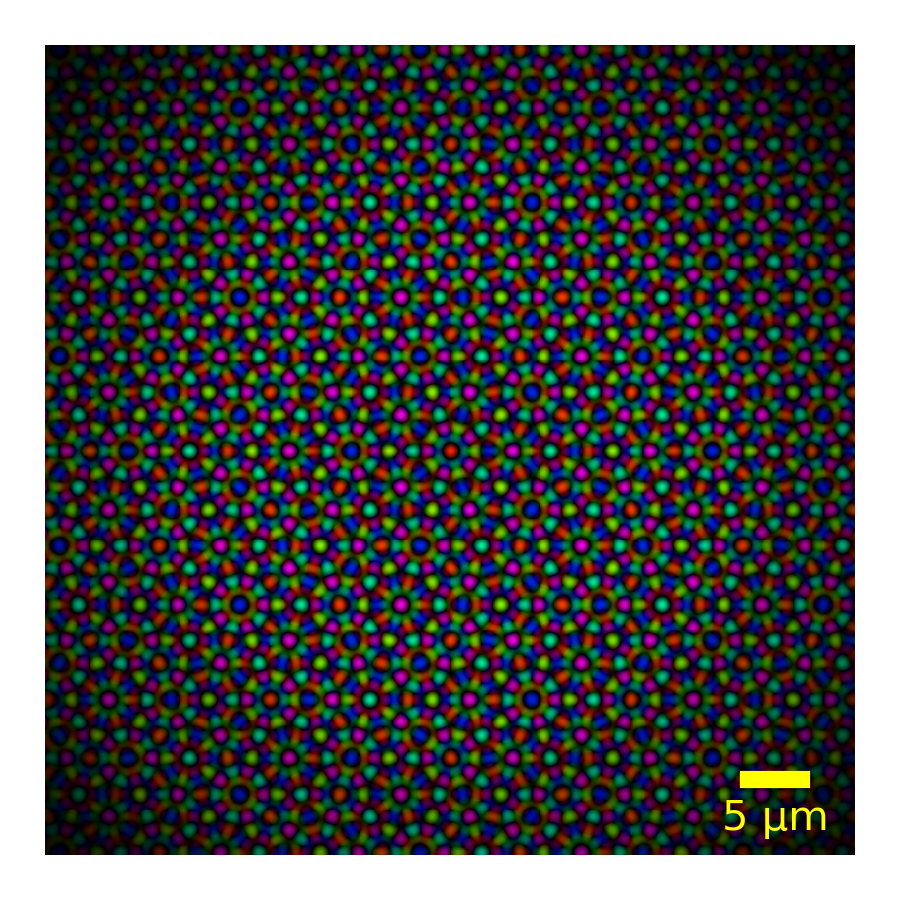

In [23]:
#generate input phase plot
fig,ax=phasorplot(imft[-1], crop=0.2, invert=False)
fig.set_size_inches((3,3), forward=True)
fig.set_dpi(300)
#ax.text(-0.24,1.05,'(a)', color='k', fontsize='12',
#            transform=ax.transAxes,
#            ha="left", va="top")
ax.set_frame_on(False)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
# Draw scale bar
ax.arrow(22e-3, -25e-3, 5e-3, 0, head_width=0, head_length=0, fc='yellow', ec='yellow')
ax.text(24.5e-3, -28e-3, u"5 μm", ha="center", va="center", size=10, color='yellow')
fig.tight_layout()
#fig.savefig("qx-output-phasor-noframe.png")

Text(6, -6.2, '2 μm')

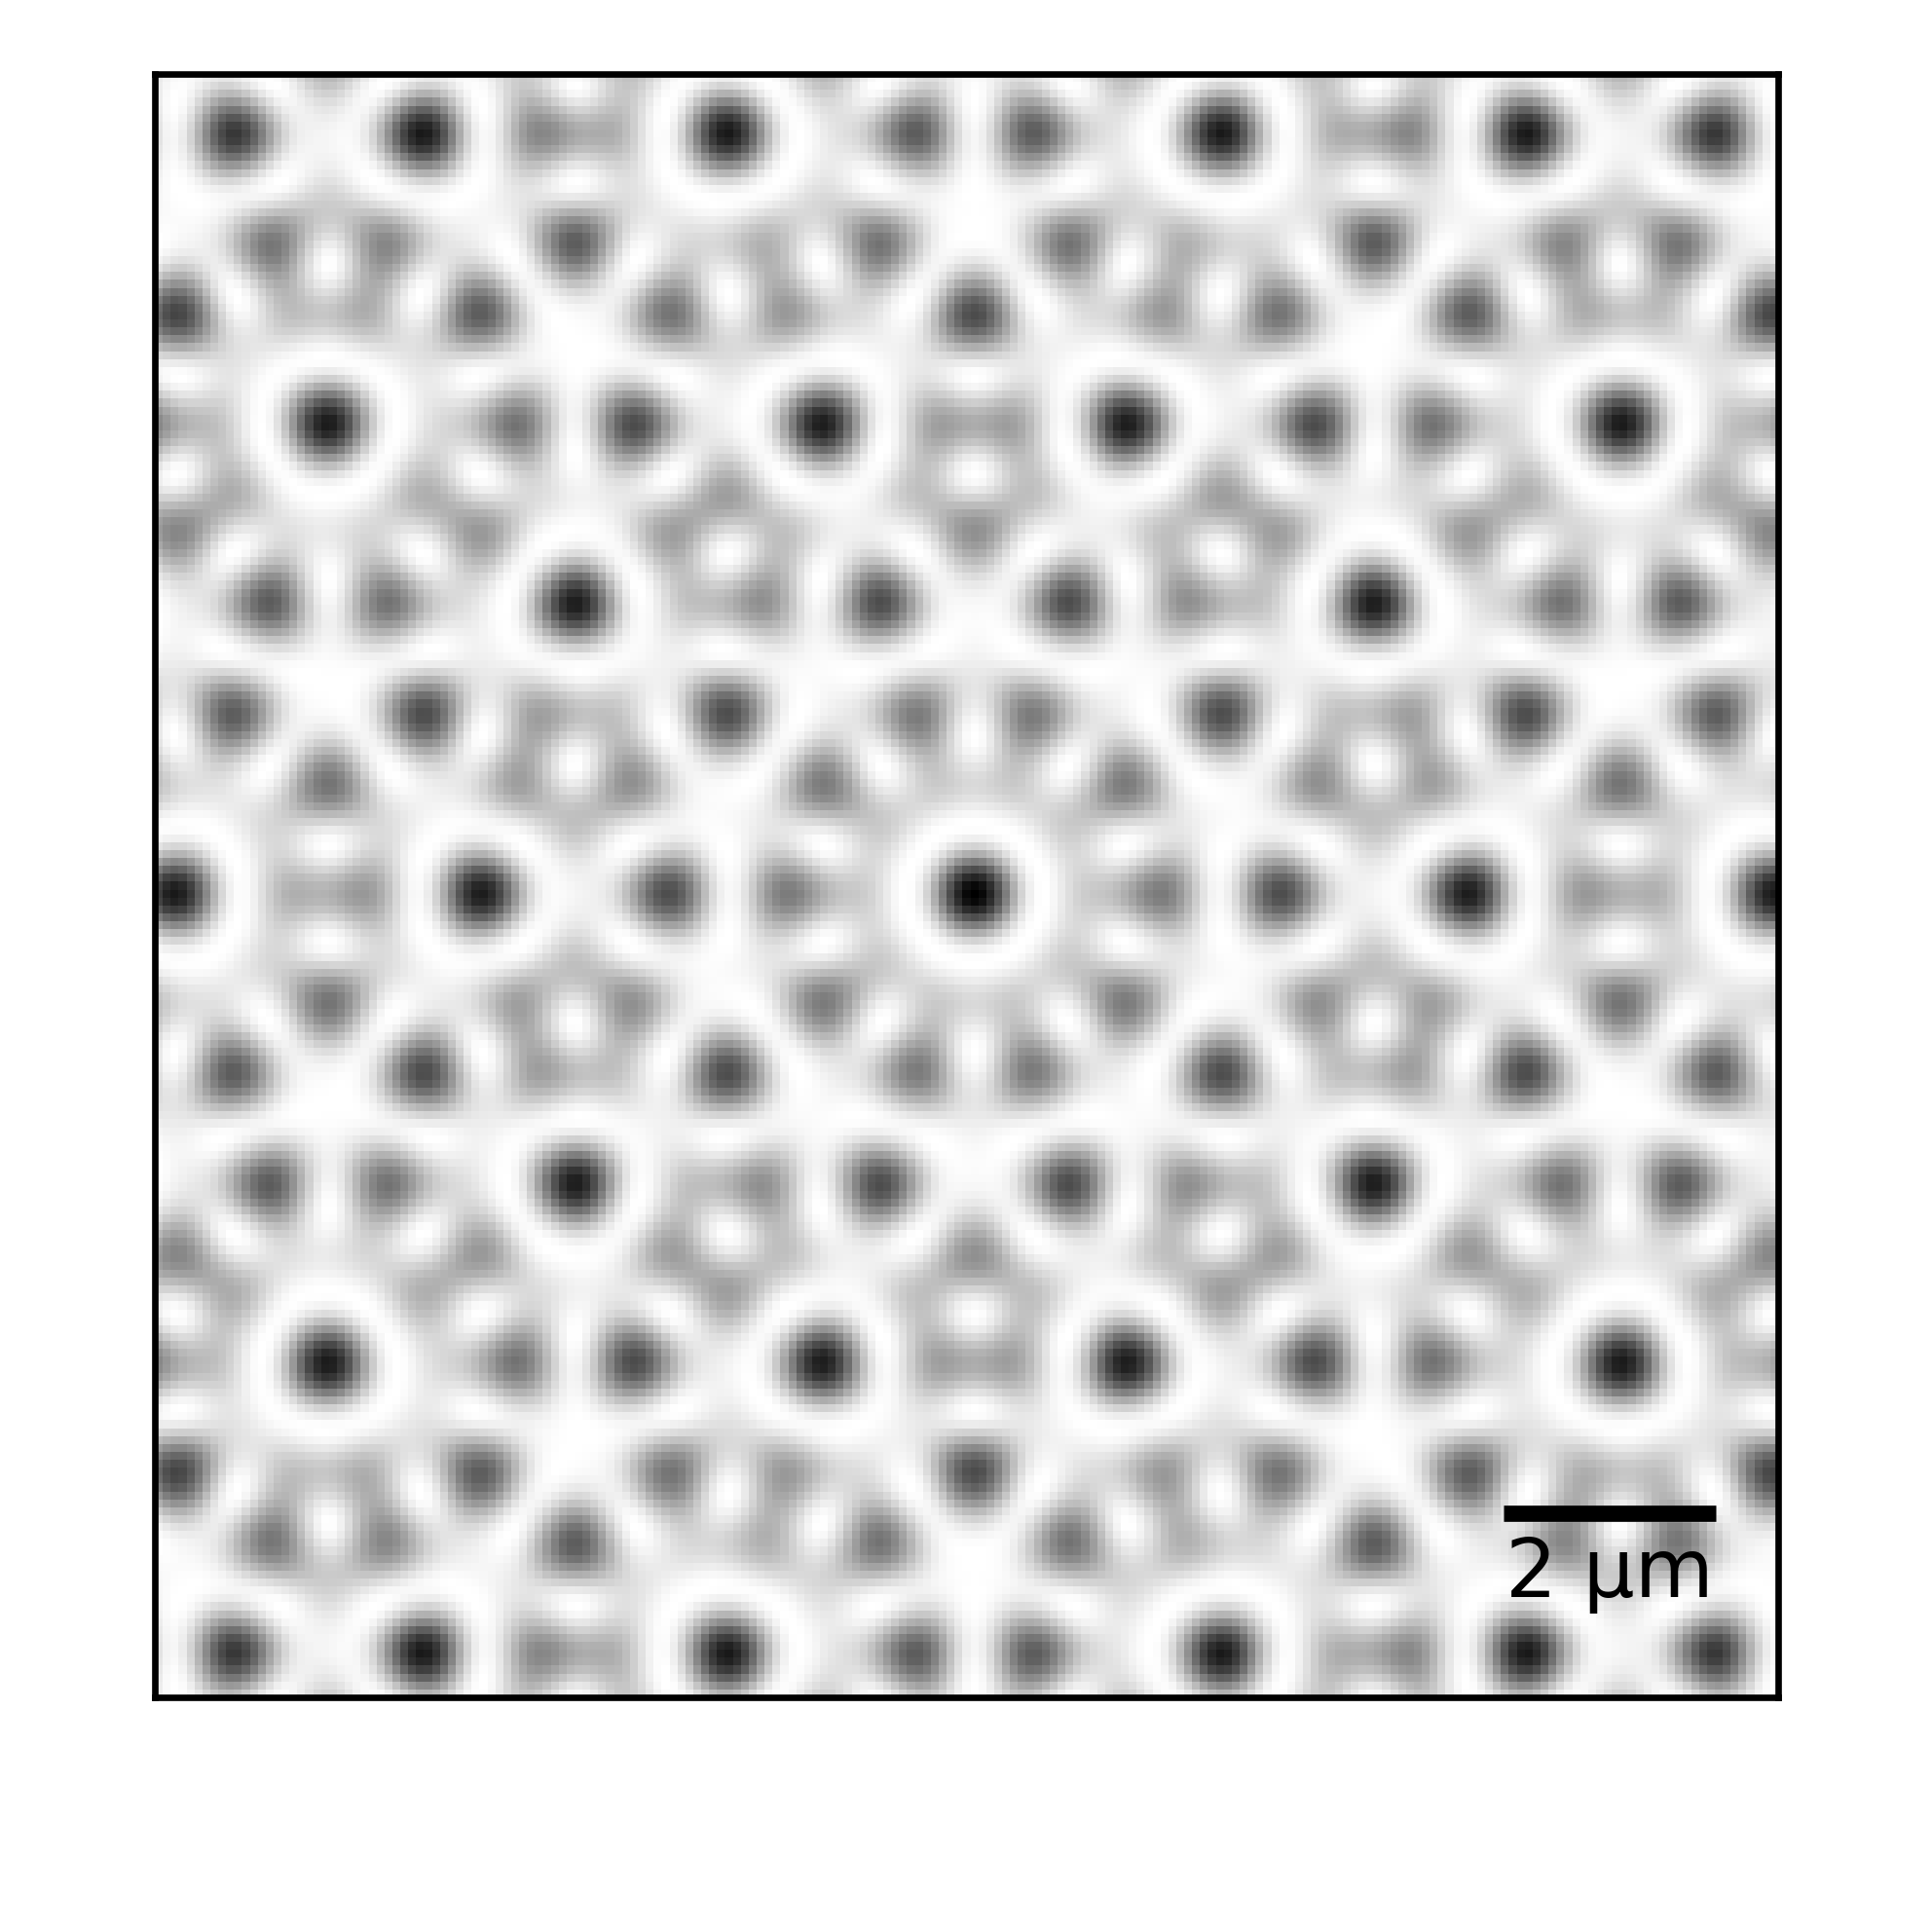

In [37]:
# generate image at atoms crop=0.05 for zoom, crop = 0.2 for large
plane=-1; crop=0.05
fig,ax=myintensityplot(imft[plane], crop=crop, invert=False)
fig.set_size_inches((josawidth,josawidth), forward=True)
fig.set_dpi(josadpi)
#ax.text(-0.27,1.05,'(b)', color='k', fontsize='12',
#            transform=ax.transAxes,
#            ha="left", va="top")
# Hide axes
ax.set_frame_on(True)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
# Draw scale bar
ax.arrow(5, -6, 2, 0, head_width=0, head_length=0, fc='black', ec='black',lw=2)
ax.text(6, -6.2, u"2 μm", ha="center", va="top", size=10, color='black')
#ax.arrow(20, -23, 5, 0, head_width=0, head_length=0, fc='k', ec='k')
#ax.text(22.5, -24, u"5 μm", ha="center", va="top", size=10, color='k')
#fig.tight_layout()
#fig.savefig("qx-atoms-rand-josab.png")

In [25]:
# conversion factors for irradiance to trapping potential
storage = imft[-1].amplitude**2
pscale = (imft[-1].pixelscale).value
area = pscale**2
convtojoule=-7.912926104232568e-36 #irradiance to joule assuming -5nm detuning 
k_boltzmann = 1.3806488e-23 # J/K
erecoil = 4.808764253879363e-30 #J
power = 0.01 # W

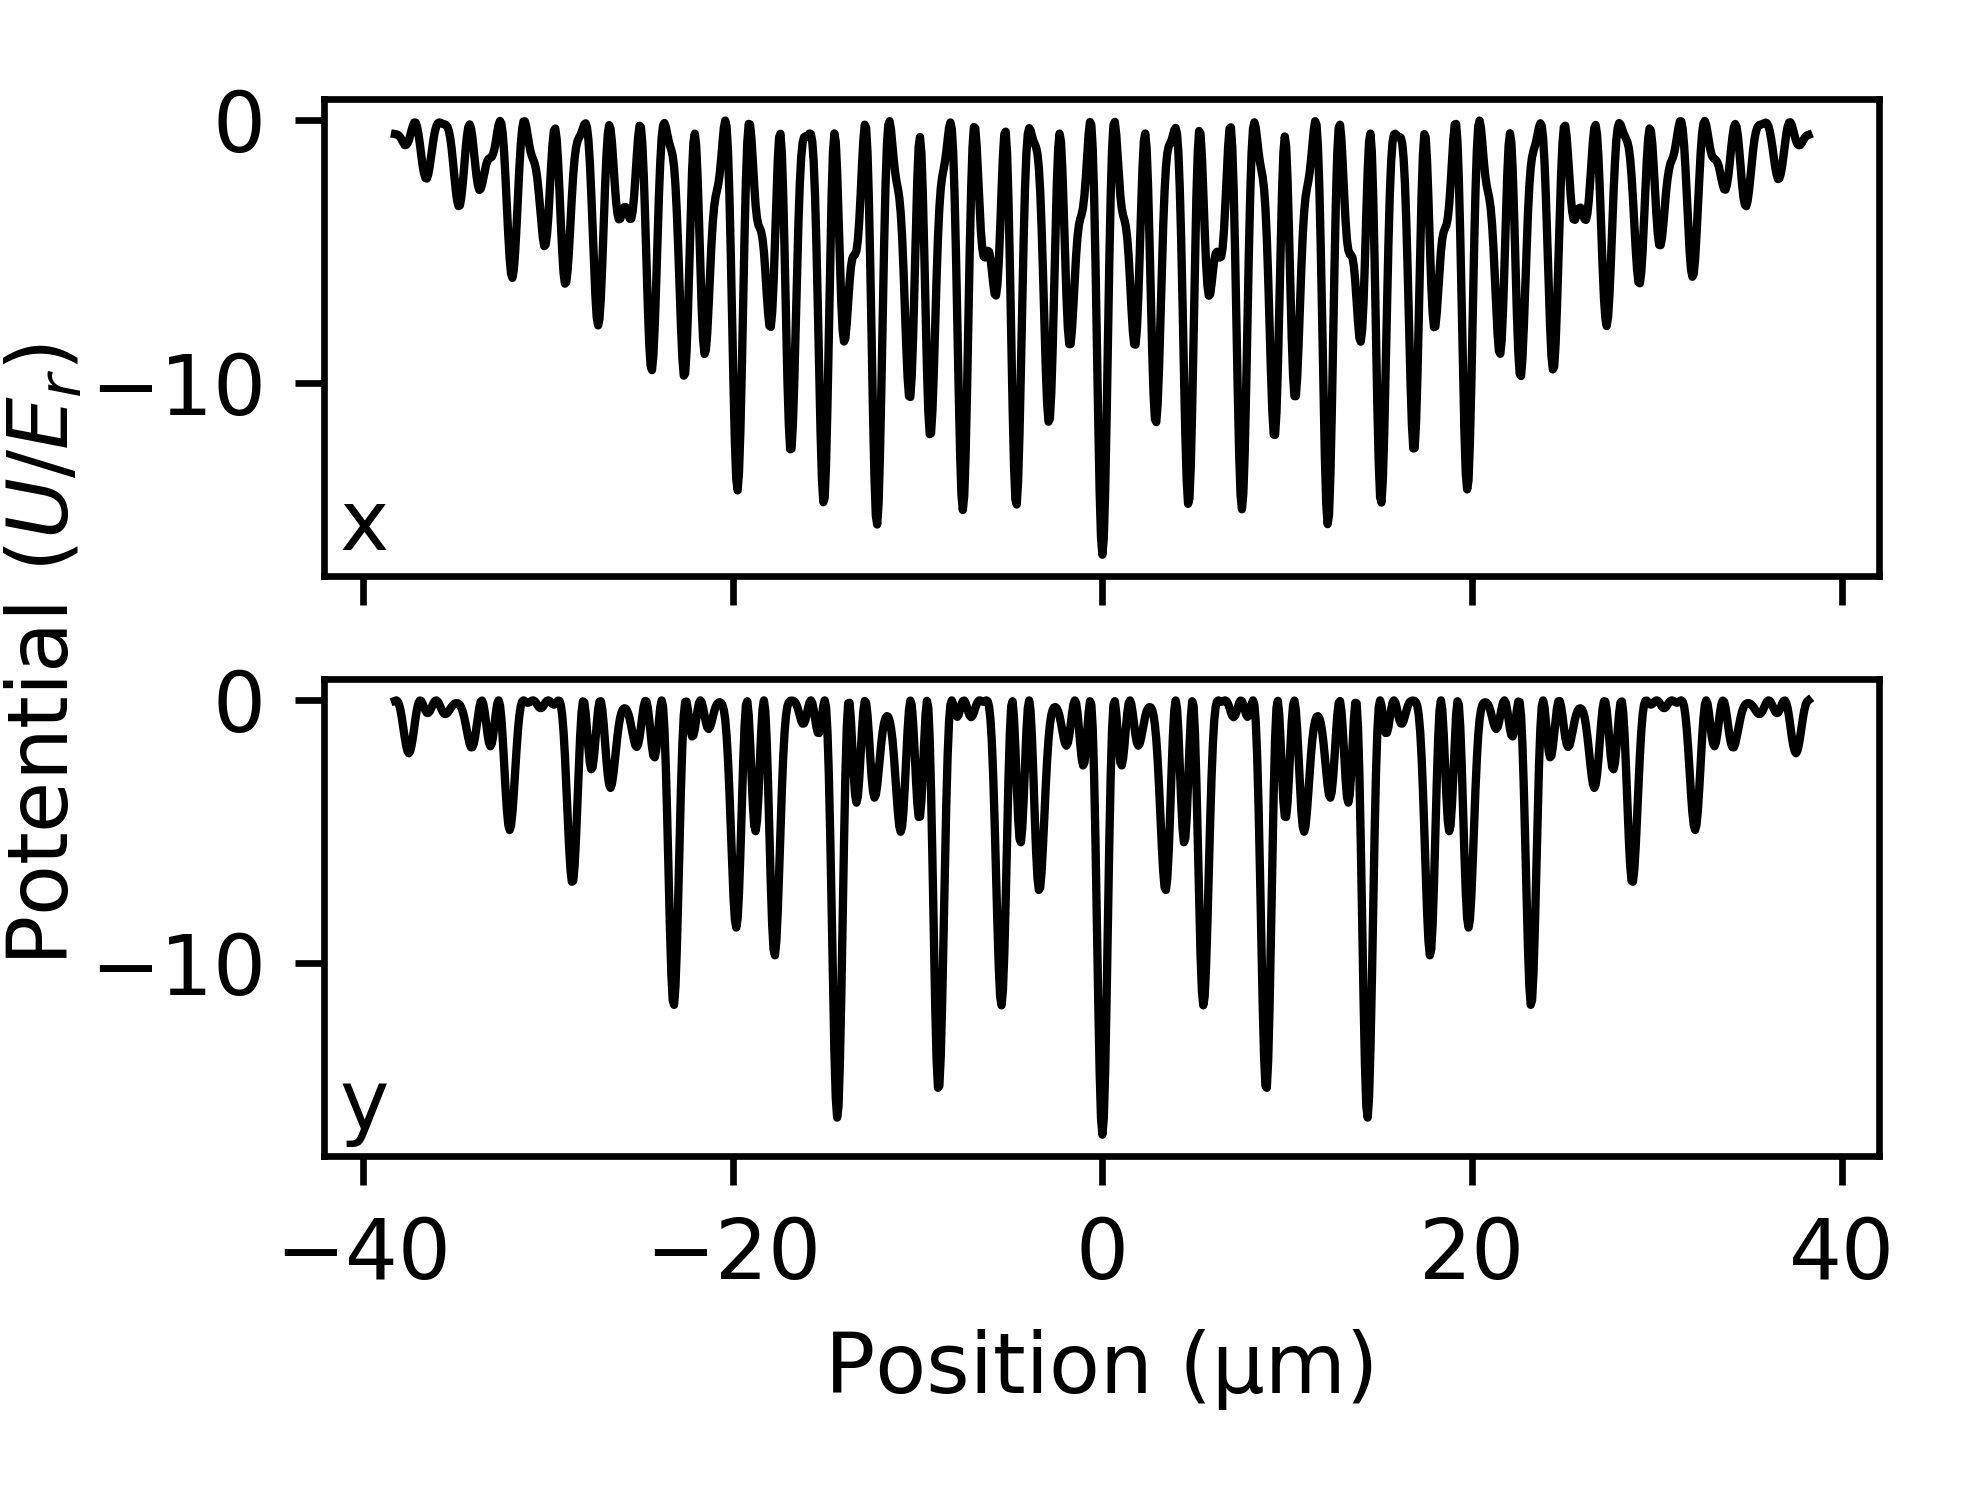

In [28]:
# generate plots of cuts through the potential
f, (ax1, ax2)=plt.subplots(2, sharex=True, sharey=True)
crop = 0.25
pmin = np.int(storage.shape[0]*0.5*(1-crop)); pmax = np.int(storage.shape[0]*0.5*(1+crop))
#1749:2348
ax1.plot(1e6*x[2048,pmin:pmax],storage[2048,pmin:pmax]/area*power*convtojoule/erecoil,
        color='k',lw=1.0)
ax2.plot(1e6*y[pmin:pmax,2048],storage[pmin:pmax,2048]/area*power*convtojoule/erecoil,
        color='k',lw=1.0)

#plt.plot(((np.arange(4096)-2047.5)*pscale2*1e6)[pmin:pmax],-1*storage2[2046,pmin:pmax].T)
#plt.plot(1e6*y[pmin:pmax,2048],gauss[pmin:pmax,2048]/area)
#plt.ylabel("Potential (K * k_B)")
#plt.ylabel("Irradiance (W/m^2)")
ax2.set_xlabel(u"Position (μm)")
#f.set_ylabel("Potential energy ($U/E_r$)")
f.subplots_adjust(left=0.2, bottom=0.2, right=0.99, top=0.95)
plt.figtext(-0.18,1.05,u'Potential $(U/E_r)$',
            transform=ax2.transAxes, rotation=90,
            ha="center", va="center"
        )
ax1.text(0.01,0.02,'x', color='k',
            transform=ax1.transAxes,
            ha="left", va="bottom")
ax2.text(0.01,0.02,'y', color='k',
            transform=ax2.transAxes,
            ha="left", va="bottom")
#ax1.text(-0.07,1,'(d)', color='k', fontsize='12',
#            transform=ax1.transAxes,
#            ha="center", va="top")
f.set_size_inches((josawidth,2.5), forward=True)
f.set_dpi(josadpi)
f.tight_layout()
#plt.savefig("qx-cut-apod.png")

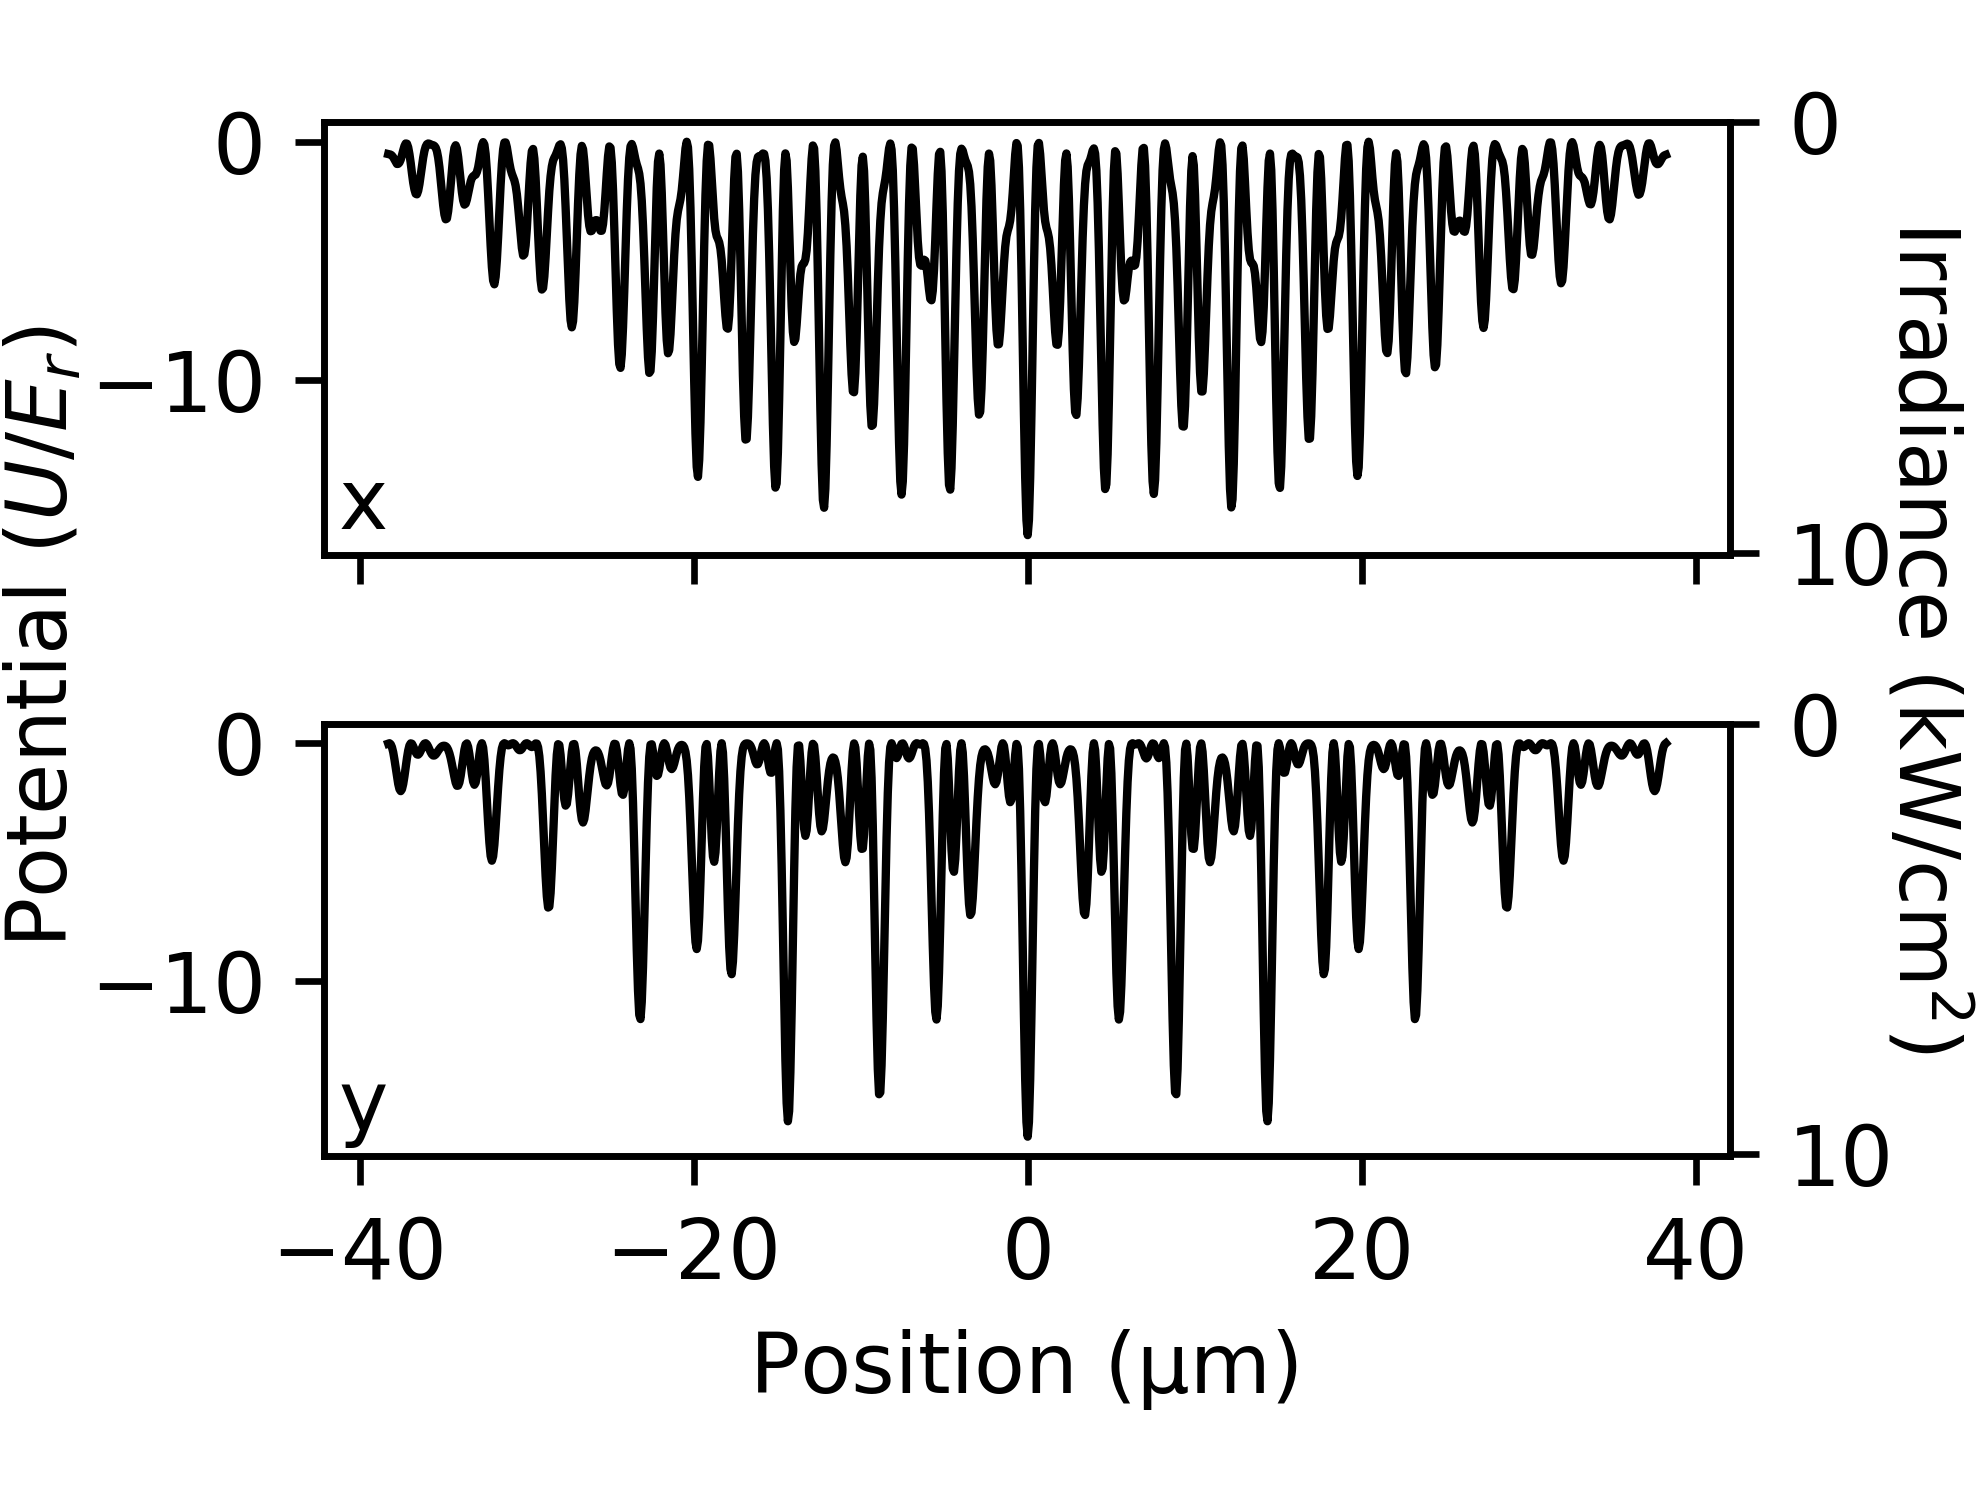

In [29]:
# plot cuts of the potential along the x and y axes
f, (ax1, ax2)=plt.subplots(2, sharex=True, sharey=True)
crop = 0.25
pmin = np.int(storage.shape[0]*0.5*(1-crop)); pmax = np.int(storage.shape[0]*0.5*(1+crop))
#1749:2348
ax1.plot(1e6*x[2048,pmin:pmax],storage[2048,pmin:pmax]/area*(power*convtojoule/erecoil),
        color='k',lw=1.0)
ax2.plot(1e6*y[pmin:pmax,2048],storage[pmin:pmax,2048]/area*(power*convtojoule/erecoil),
        color='k',lw=1.0)
ax1r = ax1.twinx()
ax2r = ax2.twinx()
ax1r.set_ylim(((storage[2048,pmin:pmax].max()/1e6)/area*power),0)
ax2r.set_ylim(((storage[pmin:pmax,2048].max()/1e6)/area*power),0)

#plt.plot(((np.arange(4096)-2047.5)*pscale2*1e6)[pmin:pmax],-1*storage2[2046,pmin:pmax].T)
#plt.plot(1e6*y[pmin:pmax,2048],gauss[pmin:pmax,2048]/area)
#plt.ylabel("Potential (K * k_B)")
#plt.ylabel("Irradiance (W/m^2)")
ax2.set_xlabel(u"Position (μm)")
#f.set_ylabel("Potential energy ($U/E_r$)")
f.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.95)
plt.figtext(-0.2,1.2,u'Potential $(U/E_r)$',
            transform=ax2.transAxes, rotation=90,
            ha="center", va="center"
        )
plt.figtext(1.14,1.2,u'Irradiance $(\mathrm{kW/cm^2})$',
            transform=ax2.transAxes, rotation=-90,
            ha="center", va="center")
ax1.text(0.01,0.02,'x', color='k',
            transform=ax1.transAxes,
            ha="left", va="bottom")
ax2.text(0.01,0.02,'y', color='k',
            transform=ax2.transAxes,
            ha="left", va="bottom")
#ax1.text(-0.07,1,'(d)', color='k', fontsize='12',
#            transform=ax1.transAxes,
#            ha="center", va="top")
f.set_size_inches((josawidth,2.5), forward=True)
f.set_dpi(josadpi)
f.tight_layout()
#plt.savefig("qx-cut-apod-2ax.png")

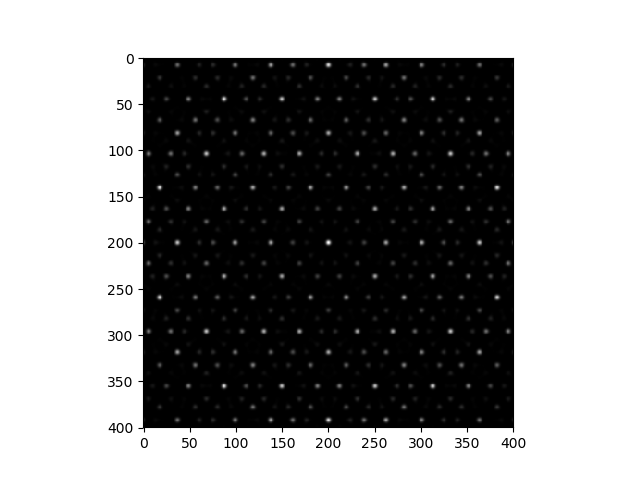

In [30]:
plt.imshow((storage[1848:2248,1848:2248])**4,cmap='gray')

In [31]:
spec=np.fft.fft2(storage)

In [32]:
spec2 = np.fft.fftshift(np.abs(spec)**2)

In [33]:
ipxscale = (1/imft[-1].pixelscale/4096/1e6).value
imin = ipxscale*-2048; imax=ipxscale*2048
extent = np.array([imin-0.5*ipxscale, imax+0.5*ipxscale,imin-0.5*ipxscale, imax+0.5*ipxscale])*2*np.pi

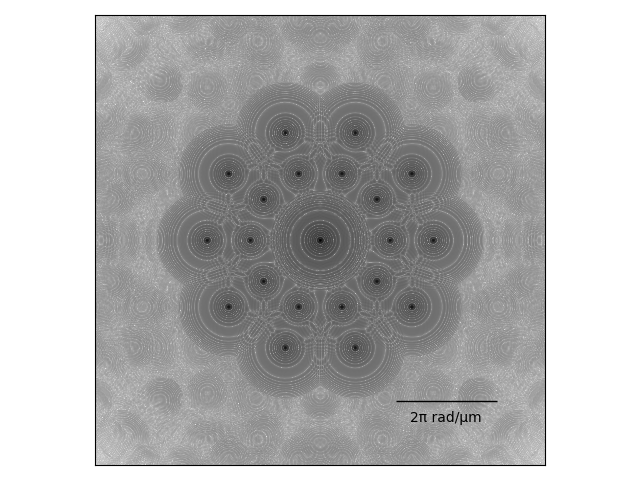

In [34]:
# generate fourier transform image
crop = 0.333
pmin = np.int(spec2.shape[0]*0.5*(1-crop)); pmax = np.int(spec2.shape[0]*0.5*(1+crop))
fig = plt.figure()
ax = plt.axes()
psdata = np.log(spec2[pmin:pmax,pmin:pmax]).T
plt.imshow(psdata,cmap='gist_yarg',extent=extent)
#plt.xlabel(u"Wavevector (rad/μm)")
#plt.ylabel(u"Wavevector (rad/μm)")
ax.set_frame_on(True)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
#fig.set_size_inches((josawidth,josawidth), forward=True)
#fig.set_dpi(josadpi)
ax.arrow(1.5*np.pi/crop, -30, 2*np.pi/crop,0, head_width=0, head_length=0, fc='k', ec='k')
ax.text(2.5*np.pi/crop, -32, u"2π rad/μm", ha="center", va="top", size=10, color='k')

fig.tight_layout()
#plt.savefig("qx-fft-josa.png")